In [1]:
import os
import numpy as np
import cv2 
from glob import glob
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda


In [2]:
path_save_images = r'E:\GitHub\AutoDoc\NN_3\DataSetGenerator\DataSet\images'
path_save_masks = r'E:\GitHub\AutoDoc\NN_3\DataSetGenerator\DataSet\masks'

In [3]:
path_train = r'E:\GitHub\AutoDoc\NN_3\DataSetGenerator\DataSet\\'

In [4]:
def load_data():
    images = sorted([os.path.join(path_save_images, path) for path in os.listdir(path_save_images)], key = lambda a: int(a.split('\\')[-1].split('_')[0]))
    masks = sorted([os.path.join(path_save_masks, path) for path in os.listdir(path_save_masks)], key = lambda a: int(a.split('\\')[-1].split('_')[0]))

    train_x,valid_x, test_x   = np.split(images, [int(.75*len(images)), int(.95*len(images))])
    train_y,valid_y, test_y  = np.split(masks, [int(.75*len(masks)), int(.95*len(masks))])
    
    return (np.concatenate([train_x, test_x], axis=0), np.concatenate([train_y, test_y], axis=0)), (valid_x, valid_y)

In [5]:
(train_x, train_y), (valid_x, valid_y) = load_data()

In [6]:
train_x, train_y

(array(['E:\\GitHub\\AutoDoc\\NN_3\\DataSetGenerator\\DataSet\\images\\0_img.JPG',
        'E:\\GitHub\\AutoDoc\\NN_3\\DataSetGenerator\\DataSet\\images\\1_img.JPG',
        'E:\\GitHub\\AutoDoc\\NN_3\\DataSetGenerator\\DataSet\\images\\2_img.JPG',
        ...,
        'E:\\GitHub\\AutoDoc\\NN_3\\DataSetGenerator\\DataSet\\images\\3081_img.JPG',
        'E:\\GitHub\\AutoDoc\\NN_3\\DataSetGenerator\\DataSet\\images\\3082_img.JPG',
        'E:\\GitHub\\AutoDoc\\NN_3\\DataSetGenerator\\DataSet\\images\\3083_img.JPG'],
       dtype='<U67'),
 array(['E:\\GitHub\\AutoDoc\\NN_3\\DataSetGenerator\\DataSet\\masks\\0_mask.png',
        'E:\\GitHub\\AutoDoc\\NN_3\\DataSetGenerator\\DataSet\\masks\\1_mask.png',
        'E:\\GitHub\\AutoDoc\\NN_3\\DataSetGenerator\\DataSet\\masks\\2_mask.png',
        ...,
        'E:\\GitHub\\AutoDoc\\NN_3\\DataSetGenerator\\DataSet\\masks\\3081_mask.png',
        'E:\\GitHub\\AutoDoc\\NN_3\\DataSetGenerator\\DataSet\\masks\\3082_mask.png',
        'E:\\GitHub\\Au

In [7]:
new_size = (256,256)
num_classes = 5

In [8]:
def read_image(path):
     path = path.decode()
     x = cv2.imread(path, cv2.IMREAD_COLOR)
     x = cv2.resize(x, new_size)
     x = x/255.0
     x = x.astype(np.float32)
     return x

In [9]:
def read_mask(path):
     path = path.decode()
     x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
     x = cv2.resize(x, (256, 256))
     x =  x.astype(np.int32)
     return x

In [11]:
from keras.utils import to_categorical

In [10]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()

In [12]:
def read_image_mask(x, y):
    """ Image """
    x = cv2.imread(x, cv2.IMREAD_COLOR)
    x = cv2.resize(x, new_size)
    x = x/255.0
    x = x.astype(np.float32)

    """ Mask """
    y = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
    y = cv2.resize(y, new_size)
    y = y.astype(np.int32)

    return x, y

def preprocess(x, y):
    def f(x, y):
        x = x.decode()
        y = y.decode()
        return read_image_mask(x, y)

    image, mask = tf.numpy_function(f, [x, y], [tf.float32, tf.int32])
    mask = tf.one_hot(mask, num_classes)

    image.set_shape([256,256, 3])
    mask.set_shape([256, 256, num_classes])

    return image, mask

def tf_dataset(X, Y, batch=8):
    ds = tf.data.Dataset.from_tensor_slices((X, Y))
    ds = ds.shuffle(buffer_size=100).map(preprocess)
    ds = ds.batch(batch).prefetch(2)
    return ds

In [13]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model

In [14]:
def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(inputs, skip, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape, num_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 32)
    s2, p2 = encoder_block(p1, 64)
    s3, p3 = encoder_block(p2, 128)
    s4, p4 = encoder_block(p3, 256)

    b1 = conv_block(p4, 512)

    d1 = decoder_block(b1, s4, 256)
    d2 = decoder_block(d1, s3, 128)
    d3 = decoder_block(d2, s2, 64)
    d4 = decoder_block(d3, s1, 32)

    outputs = Conv2D(num_classes, 1, padding="same", activation="softmax")(d4)

    model = Model(inputs, outputs)
    return model

In [15]:
batch = 8
lr = 1e-4
epochs = 300

In [16]:
train_ds = tf_dataset(train_x, train_y, batch=batch)
valid_ds = tf_dataset(valid_x, valid_y, batch=batch)

In [427]:
for x, y in train_ds:
    a = y.numpy()
    break

In [428]:
import matplotlib.pyplot as plt

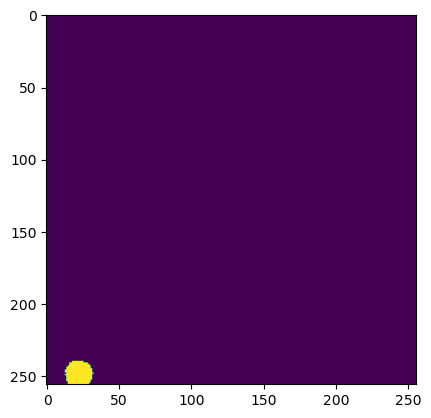

In [434]:
plt.imshow(a[0][...,4])

In [18]:
input_shape = (256, 256, 3)


In [19]:
save_path = r'E:\GitHub\AutoDoc\NN_3\result_model'

In [20]:
import os
import numpy as np
import cv2
from glob import glob
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger, TensorBoard
from concurrent.futures import ThreadPoolExecutor, wait, ALL_COMPLETED

In [21]:
model_path = os.path.join(save_path, "model.h5")
csv_path = os.path.join(save_path, "data.csv")

In [22]:
metrics=['acc',tf.keras.metrics.MeanIoU(num_classes=5)]

In [23]:
model = build_unet(input_shape, num_classes)
model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(lr),
    metrics=metrics
)

In [24]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [475]:


""" Training """
callbacks = [
    ModelCheckpoint(model_path, verbose=1, save_best_only=True, monitor='val_loss'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
    CSVLogger(csv_path, append=True),
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False)
]

model.fit(train_ds,
    validation_data=valid_ds,
    epochs=300,
    callbacks=callbacks
)

Epoch 1/300
309/309 [==============================] - ETA: 0s - loss: 1.0080 - acc: 0.8203 - mean_io_u_11: 0.4000
Epoch 1: val_loss improved from inf to 0.71994, saving model to E:\GitHub\AutoDoc\NN_3\result_model\model.h5
309/309 [==============================] - 44s 133ms/step - loss: 1.0080 - acc: 0.8203 - mean_io_u_11: 0.4000 - val_loss: 0.7199 - val_acc: 0.9798 - val_mean_io_u_11: 0.4000 - lr: 1.0000e-04
Epoch 2/300
309/309 [==============================] - ETA: 0s - loss: 0.5193 - acc: 0.9800 - mean_io_u_11: 0.4000
Epoch 2: val_loss improved from 0.71994 to 0.46013, saving model to E:\GitHub\AutoDoc\NN_3\result_model\model.h5
309/309 [==============================] - 41s 132ms/step - loss: 0.5193 - acc: 0.9800 - mean_io_u_11: 0.4000 - val_loss: 0.4601 - val_acc: 0.9799 - val_mean_io_u_11: 0.4000 - lr: 1.0000e-04
Epoch 3/300
309/309 [==============================] - ETA: 0s - loss: 0.3605 - acc: 0.9804 - mean_io_u_11: 0.4000
Epoch 3: val_loss improved from 0.46013 to 0.31899,

In [476]:
model_path = r"E:\GitHub\AutoDoc\NN_3\result_model\model.h5"

In [477]:
model = tf.keras.models.load_model(model_path)

In [478]:
x = r'E:\GitHub\AutoDoc\NN_3\DataSetGenerator\DataSet\images\0_img.JPG'
y = r'E:\GitHub\AutoDoc\NN_3\DataSetGenerator\DataSet\masks\0_mask.png'

In [479]:
image = cv2.imread(x, cv2.IMREAD_COLOR)
image = cv2.resize(image, (256, 256))
image_x = image
image = image/255.0 ## (H, W, 3)
image = np.expand_dims(image, axis=0) ## [1, H, W, 3]
image = image.astype(np.float32)

""" Reading the mask """
mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
mask = cv2.resize(mask, (256, 256))
mask = mask.astype(np.int32)

In [480]:
np.unique(mask)

array([0, 1, 2, 3, 4])

In [481]:
pred = model.predict(image, verbose=0)[0]
pred = np.argmax(pred, axis=-1) ## [0.1, 0.2, 0.1, 0.6] -> 3
pred = pred.astype(np.int32)

In [482]:
pred.shape

(256, 256)

In [483]:
pred_ = np.expand_dims(pred, axis=2)

In [484]:
pred_.shape()

TypeError: 'tuple' object is not callable

In [501]:
image = cv2.imread(x, cv2.IMREAD_COLOR)

In [502]:

contours, hierarchy = cv2.findContours(np.uint8(pred), cv2.RETR_EXTERNAL, 
cv2.CHAIN_APPROX_NONE)
 
image_ = cv2.drawContours(image, contours, -1, (0,255,0), 2)

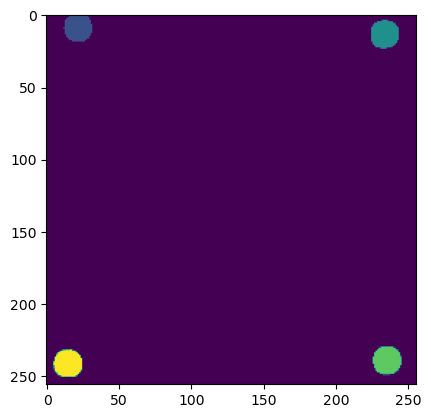

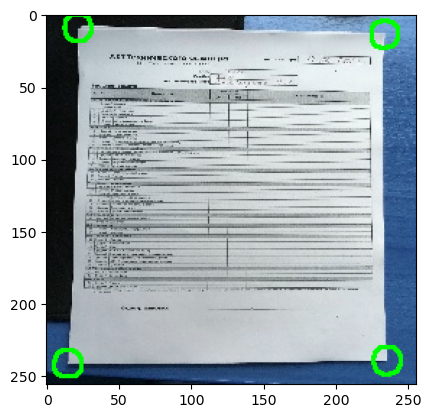

In [503]:
plt.imshow(pred)
plt.show()
plt.imshow(image)
plt.show()


In [493]:

def get_points_angle(contours):
    points_ = []
    for contour in contours:
        moment = cv2.moments(contour)
        points_.append([int(moment['m10'] / moment['m00']), int(moment['m01'] / 
        moment['m00'])])
    return points_

In [494]:
points = get_points_angle(contours)

In [505]:
for point in points:
    cv2.circle(image_, point, 2,(0,0,255),-1 )



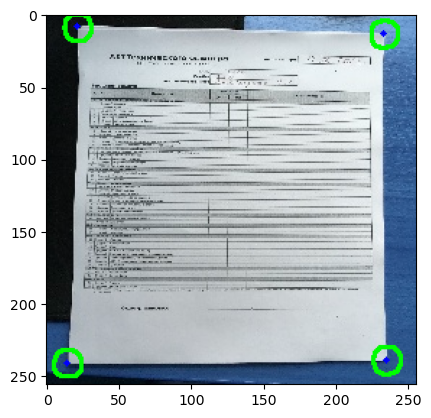

In [506]:
plt.imshow(image)
plt.show()

In [459]:
np.unique(pred)



array([0, 1, 2, 3, 4])

In [488]:
import matplotlib.pyplot as plt

In [489]:
rgb_codes  = [[0,0,0],[0, 153, 255], [102, 255, 153], [230, 0, 153],[255, 255, 102]]

In [490]:
def grayscale_to_rgb(mask, rgb_codes):
    h, w = mask.shape[0], mask.shape[1]
    mask = mask.astype(np.int32)
    output = []

    for i, pixel in enumerate(mask.flatten()):
        print(pixel)
        output.append(rgb_codes[pixel])

    output = np.reshape(output, (h, w, 3))
    return output

def save_results(image_x, mask, pred, save_image_path):
    mask = np.expand_dims(mask, axis=-1)
    mask = grayscale_to_rgb(mask, rgb_codes)

    pred = np.expand_dims(pred, axis=-1)
    pred = grayscale_to_rgb(pred, rgb_codes)

    line = np.ones((image_x.shape[0], 10, 3)) * 255

    cat_images = np.concatenate([image_x, line, mask, line, pred], axis=1)
    plt.imshow(cat_images) 


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


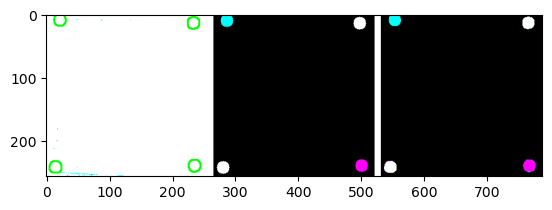

In [491]:
save_results(image,mask,pred,_)

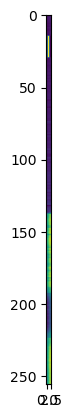

In [492]:
plt.imshow(image[0])

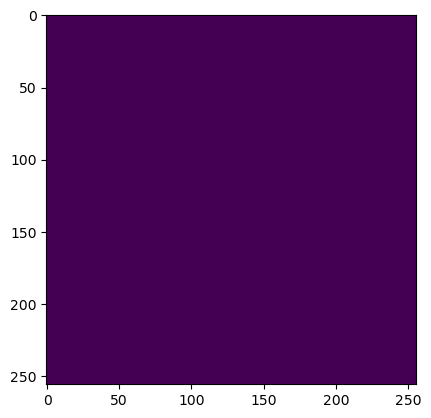

In [116]:
plt.imshow(pred*255)